# Тестовое для СДЕК летней стажировки

Задача:
Предсказать цену (price) на аренду жилья, используя не только табличные данные, но и координаты.

Сслыка: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data/data

In [231]:
import os
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# scikit
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

df = pd.read_csv("data/AB_NYC_2019.csv")

rows, cols = df.shape

print(f"Total rows: {rows}")
print(f"Total columns: {cols}")

Total rows: 48895
Total columns: 16


In [232]:
print(df.columns)

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


Колонки для анализа:
- __host_id__ - уникальные id владельца (заменим им host_name)
- __neighbourhood_group__ - боро, где расположено помещение (боро (borough) - горада Нью-Йорка, основная административная единица)
- __neighbourhood__ - районы внутри боро
- __root_type__ - тип помещения
- __minimum_nights__ - минимальное количество ночей для аренды помещения
- __number_of_reviews__ - общее количество отзывов
- __last_review__ - дата последнего отзыва
- __reviews_per_month__ - срднее количество отзывов за месяц
- __calculated_host_listings_count__ - количество объявлений от хозяина
- __availability_365__ - количество дней в году, когда жильё доступно
 Остальные колонки будут отброшены.

In [233]:
# удаляем ненужные колонки
df = df.drop(["id", "name", "host_id"], axis=1)

print(df.columns)

Index(['host_name', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


In [234]:
hosts = list(df["host_name"].unique())
print("Total hosts count:", len(hosts))
hashed = list(map(lambda x: abs(hash(x)), hosts))

if len(hosts) == len(set(hashed)):
    print("No collisions found.")
    mappings = dict(zip(hosts, hashed))
    df["host_name"] = df["host_name"].map(mappings)
    df["host_name"] /= df["host_name"].max()
else:
    raise RuntimeError("Collisionns occured!")

Total hosts count: 11453
No collisions found.


In [235]:
mask = (0 <= df["availability_365"]) & (df["availability_365"] <= 365)
df = df[mask]
df["availability_365"] /= 365

In [236]:
hosts = list(df["neighbourhood"].unique())
print("Total neighbourhoods count:", len(hosts))
hashed = list(map(lambda x: abs(hash(x)), hosts))

if len(hosts) == len(set(hashed)):
    print("No collisions found.")
    mappings = dict(zip(hosts, hashed))
    df["neighbourhood"] = df["neighbourhood"].map(mappings)
    df["neighbourhood"] /= df["neighbourhood"].max()
else:
    raise RuntimeError("Collisionns occured!")

Total neighbourhoods count: 221
No collisions found.


In [237]:
GROUPS = df["neighbourhood_group"].unique()
print("Neighbourhood groups:", GROUPS)
ROOM_TYPES = df["room_type"].unique()
print("Room types:", ROOM_TYPES)
labels_to_one_hot = ["neighbourhood_group", "room_type"]
for label in labels_to_one_hot:
    one_hot = pd.get_dummies(df[label], dtype=np.float32)
    df = df.join(one_hot)
df = df.drop(labels_to_one_hot, axis=1)

Neighbourhood groups: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
Room types: ['Private room' 'Entire home/apt' 'Shared room']


In [238]:
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

min_date = pd.to_datetime(df["last_review"]).min()
df["last_review"] = pd.to_datetime(df["last_review"].fillna(min_date))
df["last_review"] = df["last_review"].max() - df["last_review"]
df["last_review"] = df["last_review"].apply((lambda date: date.days))
df["last_review"] /= df["last_review"].max()

In [239]:
for label in ["minimum_nights", "reviews_per_month", "number_of_reviews", "calculated_host_listings_count"]:
    mask = df[label] >= 0
    df = df[mask]
    df[label] /= df[label].max()

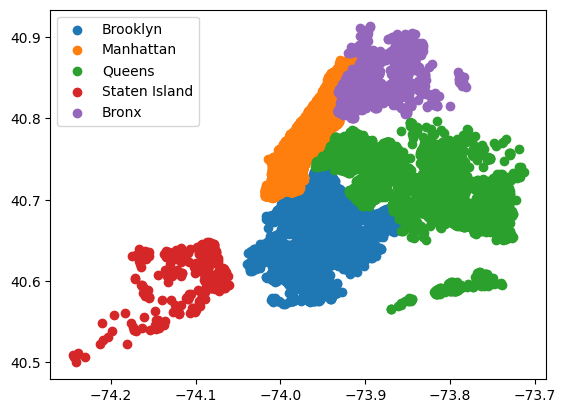

In [240]:
zones = []
for group_name in GROUPS:
    mask = df[group_name] == 1.0
    zones.append((group_name, df[mask][["longitude", "latitude"]]))

for name, zone in zones:
    plt.scatter(zone["longitude"], zone["latitude"], label=name)
plt.legend()
plt.show()

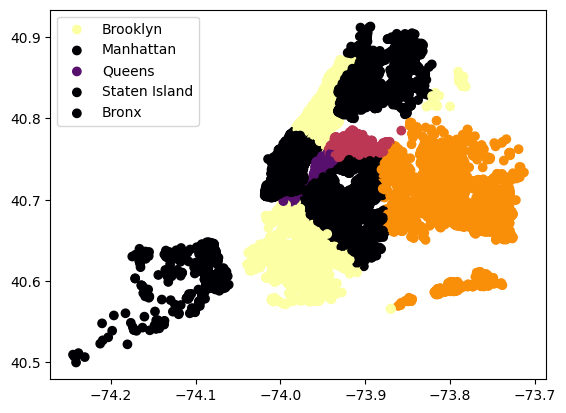

In [241]:
kmeans = KMeans(n_clusters=len(GROUPS), random_state=0)
df["location"] = kmeans.fit_predict(df[["longitude", "latitude"]])

zones = []
for group_name in GROUPS:
    mask = df[group_name] == 1.0
    zones.append((group_name, df[mask][["longitude", "latitude", "location"]]))

for name, zone in zones:
    plt.scatter(zone["longitude"], zone["latitude"], c=list(zone["location"]), cmap="inferno", label=name)
plt.legend()
plt.show()

In [242]:
df = df.drop(["longitude", "latitude"], axis=1)
df["location"] /= df["location"].max()
df.to_csv("normalized.csv", index=False)

In [243]:
print("Prices:", df["price"].min(), df["price"].max())
MEAN_PRICE = df["price"].mean()
print("Mean price:", MEAN_PRICE)

Prices: 0 10000
Mean price: 152.7206871868289


In [ ]:
X = df.drop(["price"], axis=1)
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

TypeError: 'Index' object is not callable

In [245]:
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
print(rmse / MEAN_PRICE * 100)


RMSE: 199.74777710764948
130.7928747487173
